### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns


import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score,roc_auc_score,roc_curve
from sklearn.metrics import classification_report

import xgboost as xgb
import lightgbm as lgb
import gc


from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Preprocessing

### Data loading and preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [ ]:
model_data = pd.read_csv("/content/drive/MyDrive/colab_data/chicago_food_inspection/model_data_final.csv")

model_data["datetime"] = pd.to_datetime(model_data["inspection_date"])
#model_data.sort_values("datetime", inplace=True)
df=model_data.copy()

df = df.drop(['license','facility_type', 'inspection_date', 'datetime'], axis = 1)
df.dropna(inplace=True)

dfIndexLabel = pd.DataFrame({
    "inspection_id": df.inspection_id,
    "label": df.label,
})
df=df.set_index('inspection_id')

### Standardization

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='label'), df['label'],
    test_size=0.20, random_state=1,
)

feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

## SOLUTION-1

### Class Imbalance

In [ ]:
sm = SMOTE(random_state = 42, k_neighbors=11)
X_train_oversampled_s1, y_train_oversampled_s1 = sm.fit_sample(X_train_scaled, y_train)

pd.Series(y_train_oversampled_s1).value_counts().sort_index()

0    38273
1    38273
2    38273
dtype: int64

### Modeling & Prediction

#### XGBoost (Default parameters)

CPU times: user 26.1 s, sys: 17.1 s, total: 43.2 s
Wall time: 43.9 s
Accuracy is of XGBoost 81.12152606479196
Precision of XGBoost 78.45474199078895
Recall of XGBoost 81.12152606479196
F1 score of XGBoost 79.03161326780351
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      9541
           1       0.53      0.31      0.39      2142
           2       0.61      0.43      0.51       479

    accuracy                           0.81     12162
   macro avg       0.66      0.56      0.60     12162
weighted avg       0.78      0.81      0.79     12162



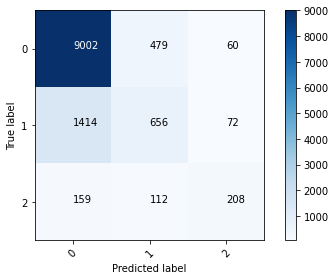

In [ ]:
classifier_xgboost = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.4,
    #subsample=0.9,
    colsample_bytree=0.6,
    missing=-999,
    random_state=2020,
    tree_method='gpu_hist'
 
)

# Fit model
%time classifier_xgboost.fit(X_train_oversampled_s1, y_train_oversampled_s1)
yhat1_xgb = classifier_xgboost.predict(X_test_scaled)

accuracy = accuracy_score(y_test, yhat1_xgb)*100
print("Accuracy is of XGBoost", accuracy)

precision = precision_score(y_test, yhat1_xgb, average='weighted')*100
print("Precision of XGBoost", precision)

recall = recall_score(y_test, yhat1_xgb,average='weighted')*100
print("Recall of XGBoost", recall)

f1 = f1_score(y_test, yhat1_xgb,average='weighted')*100
print("F1 score of XGBoost", f1)

labels = [0,1,2] 
print(classification_report(y_test, yhat1_xgb, labels)) 
cnf_matrix = confusion_matrix(y_test, yhat1_xgb, labels=labels)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) 
threshold = cnf_matrix.max() / 2 
for i in range(cnf_matrix.shape[0]): 
    for j in range(cnf_matrix.shape[1]): 
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) 
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()

## SOLUTION-2

### Feature Engineering

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=10,n_jobs=-1)      
rfe = RFE(estimator=clf_rf, n_features_to_select=10, step=1)
rfe = rfe.fit(X_train_scaled, y_train)

In [ ]:
print('Chosen best 10 feature by rfe:',X_train.columns[rfe.support_])

Chosen best 10 feature by rfe: Index(['critical_count', 'minor_count', 'past_minor', 'time_since_last',
       'age_at_inspection', 'burglary_kde', 'temperature_max', 'humidity',
       'precip_intensity', 'wind_speed'],
      dtype='object')


### Class Imbalance

In [ ]:
x_train_s2 = rfe.transform(X_train_scaled)
x_test_s2 = rfe.transform(X_test_scaled)

In [ ]:
sm = SMOTE(random_state = 42)
X_train_oversampled_s2, y_train_oversampled_s2 = sm.fit_sample(x_train_s2, y_train)
pd.Series(y_train_oversampled).value_counts().sort_index()

0    38302
1    38302
2    38302
dtype: int64

### Modeling & predictions

#### Random Forest (Default parameters)





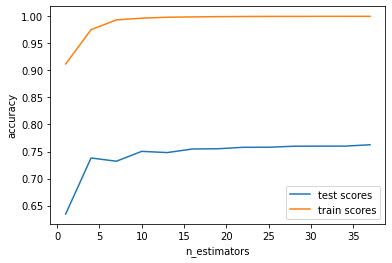

In [ ]:
train_scores = []
test_scores = []

rf = RandomForestClassifier(warm_start=True, random_state=0,n_jobs=-1)
estimator_range = range(1, 40, 3)
for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train_oversampled_s2,y_train_oversampled_s2)
    train_scores.append(rf.score(X_train_oversampled_s2,y_train_oversampled_s2))
    test_scores.append(rf.score(x_test_s2, y_test))

plt.plot(estimator_range, test_scores, label="test scores")
plt.plot(estimator_range, train_scores, label="train scores")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()

CPU times: user 4.45 s, sys: 16.5 ms, total: 4.47 s
Wall time: 2.32 s
Accuracy is of RandomForest 74.856109192567
Precision of RandomForest 73.62385475194337
Recall of RandomForest 74.856109192567
F1 score of RandomForest 74.1319482587073
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      9512
           1       0.37      0.29      0.33      2222
           2       0.30      0.38      0.34       428

    accuracy                           0.75     12162
   macro avg       0.50      0.52      0.51     12162
weighted avg       0.74      0.75      0.74     12162



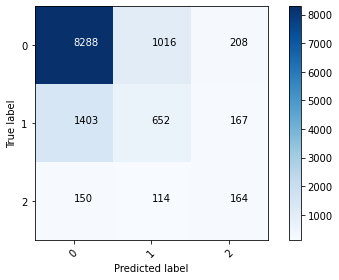

In [ ]:
#random forest classifier with n_estimators=10 (default)
classifier_rf = RandomForestClassifier(n_estimators=10,n_jobs=-1)      
%time classifier_rf = classifier_rf.fit(X_train_oversampled_s2,y_train_oversampled_s2)

yhat1_rf=classifier_rf.predict(x_test_s2)

accuracy_rf = accuracy_score(y_test, yhat1_rf)*100
print("Accuracy is of RandomForest", accuracy_rf)

precision_rf = precision_score(y_test, yhat1_rf, average='weighted')*100
print("Precision of RandomForest", precision_rf)

recall_rf = recall_score(y_test, yhat1_rf,average='weighted')*100
print("Recall of RandomForest", recall_rf)

f1_rf = f1_score(y_test, yhat1_rf,average='weighted')*100
print("F1 score of RandomForest", f1_rf)

labels = [0,1,2] 
print(classification_report(y_test, yhat1_rf, labels)) 
cnf_matrix = confusion_matrix(y_test, yhat1_rf, labels=labels)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) 
threshold = cnf_matrix.max() / 2 
for i in range(cnf_matrix.shape[0]): 
    for j in range(cnf_matrix.shape[1]): 
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) 
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()

#### XGBoost (Default parameters)


CPU times: user 18.1 s, sys: 7.48 s, total: 25.6 s
Wall time: 25.6 s
Accuracy is of XGBoost 79.86350929123499
Precision of XGBoost 76.76603343937106
Recall of XGBoost 79.86350929123499
F1 score of XGBoost 77.37797039025955
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      9512
           1       0.52      0.28      0.36      2222
           2       0.48      0.35      0.40       428

    accuracy                           0.80     12162
   macro avg       0.61      0.52      0.55     12162
weighted avg       0.77      0.80      0.77     12162



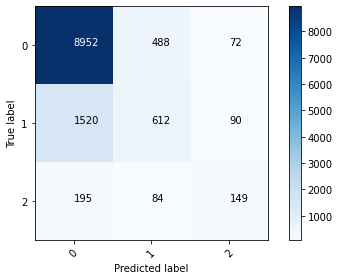

In [ ]:
classifier_xgb = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.4,
    #subsample=0.9,
    colsample_bytree=0.6,
    missing=-999,
    random_state=2020,
    tree_method='gpu_hist'
)

%time classifier_xgb.fit(X_train_oversampled_s2,y_train_oversampled_s2)
yhat1_xgb = classifier_xgb.predict(x_test_s2)

accuracy_xgb = accuracy_score(y_test, yhat1_xgb)*100
print("Accuracy is of XGBoost", accuracy_xgb)

precision_xgb = precision_score(y_test, yhat1_xgb, average='weighted')*100
print("Precision of XGBoost", precision_xgb)

recall_xgb = recall_score(y_test, yhat1_xgb,average='weighted')*100
print("Recall of XGBoost", recall_xgb)

f1_xgb = f1_score(y_test, yhat1_xgb,average='weighted')*100
print("F1 score of XGBoost", f1_xgb)

labels = [0,1,2] 
print(classification_report(y_test, yhat1_xgb, labels)) 
cnf_matrix = confusion_matrix(y_test, yhat1_xgb, labels=labels)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) 
threshold = cnf_matrix.max() / 2 
for i in range(cnf_matrix.shape[0]): 
    for j in range(cnf_matrix.shape[1]): 
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) 
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()

## SOLUTION-3

### Class Imbalance

In [ ]:
sm = SMOTE(random_state = 7, k_neighbors=11)
X_train_oversampled_s3, y_train_oversampled_s3 = sm.fit_sample(X_train_scaled, y_train)

pd.Series(y_train_oversampled_s3).value_counts().sort_index()

0    38302
1    38302
2    38302
dtype: int64

### Modeling & prediction

#### XGBoost Hyperopt (Parameter tuning)


In [ ]:
search_spaces = {
        'learning_rate': hp.uniform('learning_rate',0.01, 1.0),
        'min_child_weight': hp.choice('min_child_weight',[0,2,4,6,8,10]),
        'max_depth': hp.choice("max_depth",[0,10,20,30,40,50]),
        'max_delta_step': hp.choice('max_delta_step',[0,2,4,6,8,10,12,14,16,18,20]),
        'subsample': hp.uniform('subsample',0.01, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree',0.5, 1.0),
        'colsample_bylevel': hp.uniform('colsample_bylevel',0.5, 1.0),
        'reg_lambda': hp.uniform('reg_lambda',0.01, 1000),
        'reg_alpha': hp.uniform('reg_alpha',0.01, 1.0),
        'gamma': hp.uniform('gamma',0.01, 0.5),
        'min_child_weight': hp.choice('min_child_weight',[0,1,2,3,4,5]),
        'n_estimators': 1000,
        'seed' : 0
    }

def objective(search_spaces):
    clf=xgb.XGBClassifier(
                    max_depth = int(search_spaces['max_depth']),
                    n_estimators = int(search_spaces['n_estimators']),                   
                    min_child_weight=search_spaces['min_child_weight'],
                    gamma = search_spaces['gamma'],
                    reg_alpha = search_spaces['reg_alpha'],
                    reg_lambda = search_spaces['reg_lambda'],
                    colsample_bylevel = search_spaces['colsample_bylevel'],
                    colsample_bytree=search_spaces['colsample_bytree'],
                    subsample = search_spaces['subsample'],
                    max_delta_step=search_spaces['max_delta_step'],
                    learning_rate = search_spaces['learning_rate'],
                    n_jobs=-1                    
                    )
    
    evaluation = [( X_train_oversampled_s3
                   ,y_train_oversampled_s3)
                   ,( X_test_scaled, y_test)]
    
    clf.fit(X_train_oversampled_s3, y_train_oversampled_s3,
            eval_set=evaluation,
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

best_hyperparams = fmin(fn = objective,
                        space =search_spaces,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = Trials())

SCORE:
0.778079263279066
SCORE:
0.7929616839335636
SCORE:
0.7737214273968097
SCORE:
0.7798059529682618
SCORE:
0.7902483144219701
SCORE:
0.7713369511593487
SCORE:
0.7779148166419997
SCORE:
0.7821082058871897
SCORE:
0.7821082058871897
SCORE:
0.7889327413254399
100%|██████████| 10/10 [1:13:26<00:00, 440.60s/it, best loss: -0.7929616839335636]


In [ ]:
best_hyperparams_xgb = best_hyperparams
print("The best hyperparameters are : ","\n")
print(best_hyperparams_xgb)

The best hyperparameters are :  

{'colsample_bylevel': 0.5938041704831979, 'colsample_bytree': 0.6464242225526211, 'gamma': 0.37819015073026313, 'learning_rate': 0.4101555036953952, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 0, 'reg_alpha': 0.6393684356490666, 'reg_lambda': 290.96741054675834, 'subsample': 0.6795919151863579}


CPU times: user 18min 27s, sys: 1.33 s, total: 18min 29s
Wall time: 9min 20s
Accuracy is of XGBoost 80.14306857424765
Precision of XGBoost 77.62612996283835
Recall of XGBoost 80.14306857424765
F1 score of XGBoost 78.04112936294892
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      9512
           1       0.54      0.29      0.38      2222
           2       0.43      0.46      0.45       428

    accuracy                           0.80     12162
   macro avg       0.61      0.56      0.57     12162
weighted avg       0.78      0.80      0.78     12162



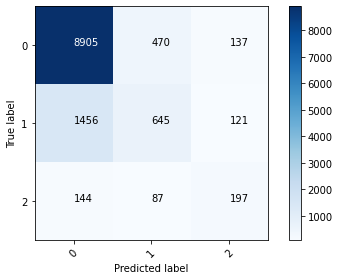

In [ ]:
clf=xgb.XGBClassifier(               
                    max_depth = int(best_hyperparams_xgb['max_depth']),
                    n_estimators = 1000,                   
                    min_child_weight=best_hyperparams_xgb['min_child_weight'],
                    gamma = best_hyperparams_xgb['gamma'],
                    reg_alpha = best_hyperparams_xgb['reg_alpha'],
                    reg_lambda = best_hyperparams_xgb['reg_lambda'],
                    colsample_bylevel = best_hyperparams_xgb['colsample_bylevel'],
                    colsample_bytree=best_hyperparams_xgb['colsample_bytree'],
                    subsample = best_hyperparams_xgb['subsample'],
                    max_delta_step=best_hyperparams_xgb['max_delta_step'],
                    learning_rate = best_hyperparams_xgb['learning_rate'],
                    n_jobs=-1)

# Fit model
%time clf.fit(X_train_oversampled_s3, y_train_oversampled_s3)
yhat1 = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, yhat1)*100
print("Accuracy is of XGBoost", accuracy)

precision = precision_score(y_test, yhat1, average='weighted')*100
print("Precision of XGBoost", precision)

recall = recall_score(y_test, yhat1,average='weighted')*100
print("Recall of XGBoost", recall)

f1 = f1_score(y_test, yhat1,average='weighted')*100
print("F1 score of XGBoost", f1)

labels = [0,1,2] 
print(classification_report(y_test, yhat1, labels)) 
cnf_matrix = confusion_matrix(y_test, yhat1, labels=labels)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) 
threshold = cnf_matrix.max() / 2 
for i in range(cnf_matrix.shape[0]): 
    for j in range(cnf_matrix.shape[1]): 
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) 
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()

#### RandomForest Hyperopt (Parameter tuning)


In [ ]:
search_spaces_rf = {
        'n_estimators': hp.choice("n_estimators",[1,5,10,15,20]), 
        'max_depth': hp.choice("max_depth",[1,10,20,30,40,50]),
        'min_samples_split': hp.choice("min_samples_split",[2, 5, 10,50,100]),
        'criterion': hp.choice("criterion",['gini', 'entropy'])
    }

def objective(search_spaces_rf):
    clf=RandomForestClassifier(
                    max_depth = int(search_spaces_rf['max_depth']),
                    n_estimators = int(search_spaces_rf['n_estimators']),
                    min_samples_split = search_spaces_rf['min_samples_split'],
                    criterion = search_spaces_rf['criterion'],
                    n_jobs=-1                    
                    )
    
    clf.fit(X_train_oversampled_s3, y_train_oversampled_s3)
    

    pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

best_hyperparams = fmin(fn = objective,
                        space =search_spaces_rf,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = Trials())

SCORE:
0.7102450254892287
SCORE:
0.7077783259332346
SCORE:
0.7266074658773228
SCORE:
0.6788357178095707
SCORE:
0.7593323466535109
SCORE:
0.7100805788521625
SCORE:
0.736967604012498
SCORE:
0.6882913994408815
SCORE:
0.6990626541687223
SCORE:
0.7364742641012991
SCORE:
0.7604834731129748
SCORE:
0.7128761716822891
SCORE:
0.7572767636901825
SCORE:
0.7487255385627364
SCORE:
0.7349942443677027
SCORE:
0.740585430027956
SCORE:
0.7512744614372636
SCORE:
0.7507811215260648
SCORE:
0.6758756783423779
SCORE:
0.6267061338595625
SCORE:
0.7579345502384476
SCORE:
0.7606479197500411
SCORE:
0.7639368524913666
SCORE:
0.7597434632461766
SCORE:
0.759414569972044
SCORE:
0.7629501726689689
SCORE:
0.6675711231705311
SCORE:
0.6827002137806282
SCORE:
0.6646933070218713
SCORE:
0.6221838513402401
SCORE:
0.7659102121361618
SCORE:
0.7497944417036672
SCORE:
0.7375431672422299
SCORE:
0.7571945403716493
SCORE:
0.765416872224963
SCORE:
0.7457654990955435
SCORE:
0.7083538891629666
SCORE:
0.7407498766650222
SCORE:
0.7658279

In [ ]:
best_hyperparams_rf = best_hyperparams
print("The best hyperparameters are : ","\n")
print(best_hyperparams_rf)

The best hyperparameters are :  

{'criterion': 0, 'max_depth': 5, 'min_samples_split': 1, 'n_estimators': 4}


CPU times: user 528 ms, sys: 3 ms, total: 531 ms
Wall time: 336 ms
Accuracy is of XGBoost 61.700378227265254
Precision of XGBoost 72.63685816574001
Recall of XGBoost 61.700378227265254
F1 score of XGBoost 65.73555848213495
              precision    recall  f1-score   support

           0       0.86      0.69      0.77      9512
           1       0.25      0.28      0.27      2222
           2       0.15      0.73      0.25       428

    accuracy                           0.62     12162
   macro avg       0.42      0.57      0.43     12162
weighted avg       0.73      0.62      0.66     12162



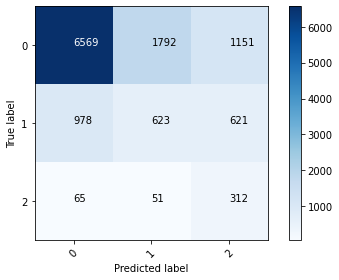

In [ ]:
clf=RandomForestClassifier(
                    max_depth = int(best_hyperparams_rf['max_depth']),
                    n_estimators = int(best_hyperparams_rf['n_estimators']),
                    min_samples_split = 2,
                    criterion = 'gini',
                    n_jobs=-1                    
                    )
# Fit model
%time clf.fit(X_train_oversampled_s3, y_train_oversampled_s3)
yhat1 = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, yhat1)*100
print("Accuracy is of XGBoost", accuracy)

precision = precision_score(y_test, yhat1, average='weighted')*100
print("Precision of XGBoost", precision)

recall = recall_score(y_test, yhat1,average='weighted')*100
print("Recall of XGBoost", recall)

f1 = f1_score(y_test, yhat1,average='weighted')*100
print("F1 score of XGBoost", f1)

labels = [0,1,2] 
print(classification_report(y_test, yhat1, labels)) 
cnf_matrix = confusion_matrix(y_test, yhat1, labels=labels)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) 
threshold = cnf_matrix.max() / 2 
for i in range(cnf_matrix.shape[0]): 
    for j in range(cnf_matrix.shape[1]): 
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) 
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()

#### LightGBM Hyperopt (Parameter tuning)


In [ ]:
#GLOBAL HYPEROPT PARAMETERS
NUM_EVALS = 10 #number of hyperopt evaluation rounds
N_FOLDS = 5 #number of cross-validation folds on data in each evaluation round

#LIGHTGBM PARAMETERS
LGBM_MAX_LEAVES = 2**11 #maximum number of leaves per tree for LightGBM
LGBM_MAX_DEPTH = 25 #maximum tree depth for LightGBM
EVAL_METRIC_LGBM_REG = 'mae' #LightGBM regression metric. Note that 'rmse' is more commonly used 
EVAL_METRIC_LGBM_CLASS = 'multi_logloss'#LightGBM classification metric

#OPTIONAL OUTPUT
BEST_SCORE = 0

def quick_hyperopt(data, labels, package, num_evals=NUM_EVALS, diagnostic=False):

    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        gc.collect()
        
        integer_params = ['max_depth',
                         'num_leaves',
                         'max_bin',
                         'min_data_in_leaf',
                         'min_data_in_bin',
                         'num_class']
        
        def objective(space_params):
            
            
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            
            cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=True,
                                early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_CLASS, seed=42)
            
            
            best_loss = 1 - cv_results['multi_logloss-mean'][-1]
           
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] 

        metric_list = ['multi_logloss']
        objective_list_reg = ['huber', 'gamma', 'fair', 'tweedie']
        objective_list_class = ['multiclass']

        objective_list = objective_list_class

        space ={'boosting' : hp.choice('boosting', boosting_list),
                'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                'max_bin': hp.quniform('max_bin', 32, 255, 1),
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01),
                'num_class' : hp.choice('num_class', [3])
            }
        

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
                

        best['boosting'] = boosting_list[best['boosting']]['boosting']
        best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]

        for param in integer_params:
            best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)
      

In [ ]:
lgbm_params = quick_hyperopt(X_train_oversampled_s3, y_train_oversampled_s3, 'lgbm', 200)

Running 200 rounds of LightGBM parameter optimisation:
100%|██████████| 200/200 [2:15:23<00:00, 40.62s/it, best loss: -0.0038563181055242257]
{bagging_fraction: 0.88
boosting: goss
feature_fraction: 0.55
lambda_l1: 4.781578442106322
lambda_l2: 1.081777567931213
learning_rate: 0.005031221621782062
max_bin: 169
max_depth: 2
metric: multi_logloss
min_data_in_bin: 10
min_data_in_leaf: 151
min_gain_to_split: 2.88
num_class: 0
num_leaves: 1852
objective: multiclass
other_rate: 0.059286001030588925
top_rate: 0.04952478338292399}


In [ ]:
clf_lgb = lgb.LGBMClassifier(**lgbm_params)

# Fit model
%time clf_lgb.fit(X_train_oversampled_s3, y_train_oversampled_s3)
yhat1 = clf_lgb.predict(X_test_scaled)

CPU times: user 9.59 s, sys: 75.8 ms, total: 9.67 s
Wall time: 4.98 s


Accuracy is of XGBoost 65.4250945568163
Precision of XGBoost 74.17390049140164
Recall of XGBoost 65.4250945568163
F1 score of XGBoost 68.40832832257271
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      9512
           1       0.31      0.19      0.24      2222
           2       0.14      0.80      0.23       428

    accuracy                           0.65     12162
   macro avg       0.44      0.58      0.43     12162
weighted avg       0.74      0.65      0.68     12162



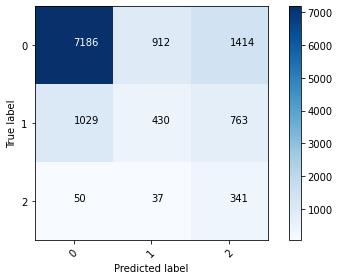

In [ ]:
accuracy = accuracy_score(y_test, yhat1)*100
print("Accuracy is of XGBoost", accuracy)

precision = precision_score(y_test, yhat1, average='weighted')*100
print("Precision of XGBoost", precision)

recall = recall_score(y_test, yhat1,average='weighted')*100
print("Recall of XGBoost", recall)

f1 = f1_score(y_test, yhat1,average='weighted')*100
print("F1 score of XGBoost", f1)

labels = [0,1,2] 
print(classification_report(y_test, yhat1, labels)) 
cnf_matrix = confusion_matrix(y_test, yhat1, labels=labels)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) 
threshold = cnf_matrix.max() / 2 
for i in range(cnf_matrix.shape[0]): 
    for j in range(cnf_matrix.shape[1]): 
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) 
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()